#Domestic (US and US territories) Flight Delay Project
## Phase 4
**w261 Final Project Team 19 Summer 2022**

Team Members: Grace Lee, Shivangi Pandey, Sybil Santos-Burgan, Beijing Wu

## Notebook Setup

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.sql import Window

import time

from scipy import stats
from scipy.stats import norm

pd.options.display.float_format = '{:.0f}'.format
from pyspark.sql.functions import col
from pyspark.sql.functions import col, max

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from pyspark.sql.functions import col,isnan,when,count
from graphframes import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.feature import StandardScaler, Imputer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from sparkdl.xgboost import XgboostClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import math
import itertools 
import random

#Set up blob access
blob_container = "261finalproject" # The name of your container created in https://portal.azure.com
storage_account = "ssburgan" # The name of your Storage account created in https://portal.azure.com
secret_scope = "261finalprojectscope1" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "bestteam" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

# Inspect the Mount's Final Project folder 
data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))


path,name,size,modificationTime
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data/,parquet_airlines_data/,0,1656618287000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_1y/,parquet_airlines_data_1y/,0,1656630272000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_3m/,parquet_airlines_data_3m/,0,1656630114000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_6m/,parquet_airlines_data_6m/,0,1656630205000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data/,parquet_weather_data/,0,1656622074000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_1y/,parquet_weather_data_1y/,0,1656631614000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_3m/,parquet_weather_data_3m/,0,1656630651000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_6m/,parquet_weather_data_6m/,0,1656631047000
dbfs:/mnt/mids-w261/datasets_final_project_2022/stations_data/,stations_data/,0,1656713663000


## Load, Transformation and Feature Engineering

In [0]:
#Read in full joined dataset 
df_join = spark.read.parquet(f"{blob_url}/base_datasets/final_joined_data")
print('initial row count:', df_join.count())

# Fill cancelled missing values in delayed column (because missing when flight cancelled, consider cancels as delays)
df_join.na.fill({'DELAYED': 1})

#Read in airline names dataset
df_airline_names = spark.read.parquet(f"{blob_url}/airline_names")
df_airline_names = df_airline_names.withColumnRenamed("Code", "Airline_Code")
df_airline_names = df_airline_names.withColumnRenamed("Description", "Airline_Description")

#Read in carrier cateogry LCC, Regional, Legacy
df_carrier_cat = spark.read.parquet(f"{blob_url}/carrier_cat_US")

#Add Hour Column
df_join = df_join.withColumn("HOUR", F.substring('CRS_DEP_TIME', 0, 2))

#Join Airline Description
df_join = df_join.join(df_airline_names, df_join.OP_CARRIER == df_airline_names.Airline_Code, "inner") 

#Join Carrier Category
df_join = df_join.join(df_carrier_cat, df_join.Airline_Code == df_carrier_cat.carrier_cat_IATA, "left") 
#Drop uncessary carrier category columns
df_join = df_join.drop(F.col("carrier_cat_airline"))
df_join = df_join.drop(F.col("carrier_cat_region"))

#Holiday data
df_holidays = spark.read.parquet(f"{blob_url}/holiday_travel_season")

# Prep holiday date column to be in correct format to join
df_holidays = df_holidays.withColumn('Holiday_Month', F.regexp_extract(col('Holiday_Date'), '^[^/]*',0))\
        .withColumn('Holiday_Day', F.regexp_extract(col('Holiday_Date'), '/(.*)/', 1))
df_holidays = df_holidays.withColumn('Holiday_Month',F.lpad("Holiday_Month",2,"0"))
df_holidays = df_holidays.withColumn('Holiday_Day',F.lpad("Holiday_Day",2,"0"))
df_holidays = df_holidays.withColumn('Date_to_join', F.concat(F.col('Holiday_Year'),F.lit('-'), F.col('Holiday_Month'), F.lit('-'), F.col('Holiday_Day')))

# Prep pre holiday date column to be in correct format to join
df_pre_holidays = df_holidays.withColumn('Holiday_Month', F.regexp_extract(col('Holiday_Start_Date'), '^[^/]*',0))\
        .withColumn('Holiday_Day', F.regexp_extract(col('Holiday_Start_Date'), '/(.*)/', 1))
df_pre_holidays = df_pre_holidays.withColumn('Holiday_Month',F.lpad("Holiday_Month",2,"0"))
df_pre_holidays = df_pre_holidays.withColumn('Holiday_Day',F.lpad("Holiday_Day",2,"0"))
df_pre_holidays = df_pre_holidays.withColumn('Pre_holiday_join', F.concat(F.col('Holiday_Year'),F.lit('-'), F.col('Holiday_Month'), F.lit('-'), F.col('Holiday_Day')))

# Prep post holiday date column to be in correct format to join
df_post_holidays = df_holidays.withColumn('Holiday_Month', F.regexp_extract(col('Holiday_End_Date'), '^[^/]*',0))\
        .withColumn('Holiday_Day', F.regexp_extract(col('Holiday_End_Date'), '/(.*)/', 1))
df_post_holidays = df_post_holidays.withColumn('Holiday_Month',F.lpad("Holiday_Month",2,"0"))
df_post_holidays = df_post_holidays.withColumn('Holiday_Day',F.lpad("Holiday_Day",2,"0"))
df_post_holidays = df_post_holidays.withColumn('Post_holiday_join', F.concat(F.col('Holiday_Year'),F.lit('-'), F.col('Holiday_Month'), F.lit('-'), F.col('Holiday_Day')))

# convert holiday date_to_join to datetime and add pre and post holiday date benchmarks (7 days prior and after)
df_holidays = df_holidays.withColumn('HOLIDAY_DATETIME', F.unix_timestamp(df_holidays.Date_to_join,"yyyy-MM-dd").cast('timestamp'))
df_pre_holidays = df_pre_holidays.withColumn('PRE_HOLIDAY_DATETIME', F.unix_timestamp(df_pre_holidays.Pre_holiday_join,"yyyy-MM-dd").cast('timestamp'))
df_post_holidays = df_post_holidays.withColumn('POST_HOLIDAY_DATETIME', F.unix_timestamp(df_post_holidays.Post_holiday_join,"yyyy-MM-dd").cast('timestamp'))

# join holidays to full data
df_join = df_join.join(df_holidays.select('Date_to_join', 'Holiday_Desc'), df_join.FL_DATE == df_holidays.Date_to_join, "left")
df_join = df_join.join(df_pre_holidays.select('Pre_holiday_join', 'PRE_HOLIDAY_DATETIME'), df_join.FL_DATE == df_pre_holidays.Pre_holiday_join, "left")
df_join = df_join.join(df_post_holidays.select('Post_holiday_join', 'POST_HOLIDAY_DATETIME'), df_join.FL_DATE == df_post_holidays.Post_holiday_join, "left")

# HOLIDAYS: create indicator for holiday, and pre and post holiday
df_join = df_join.withColumn('HOLIDAY_IND', F.when(F.col('Holiday_Desc').isNotNull(), 1).otherwise(0))
df_join = df_join.withColumn('PRE_HOLIDAY_IND', F.when(F.col('Pre_holiday_join').isNotNull(), 1).otherwise(0))
df_join = df_join.withColumn('POST_HOLIDAY_IND', F.when(F.col('Post_holiday_join').isNotNull(), 1).otherwise(0))

# Did the prior flight arrive late? create feature if prior flight arrived over 30 min late
df_join=df_join.withColumn('PRIOR_FLIGHT_LATE_ARRIVAL',F.when(F.col('ARR_DELAY')>30,1).otherwise(0))

# Graphframes Pagerank airport variable origin_airport_pagerank
nodes = df_join.select('ORIGIN').withColumnRenamed('ORIGIN', 'id').distinct()
edges = df_join.withColumn('flight_id', F.monotonically_increasing_id()).select(F.col('DELAYED'), F.col('ORIGIN').alias('src'), F.col('DEST').alias('dst'))
graph = GraphFrame(nodes, edges)
airport_ranks = graph.pageRank(resetProbability = 0.15, maxIter = 10)
ordered_airport_ranks = airport_ranks.vertices.orderBy(airport_ranks.vertices.pagerank.desc())
ordered_airport_ranks = ordered_airport_ranks.withColumnRenamed('id', 'pagerank_id')
ordered_airport_ranks = ordered_airport_ranks.withColumnRenamed('pagerank', 'origin_airport_pagerank')

df_join = df_join.join(ordered_airport_ranks, df_join.ORIGIN == ordered_airport_ranks.pagerank_id, 'left')

# make sure joins did not duplicate any records
print('end row count', df_join.count())
display(df_join)

initial row count: 42430592

## Split Data

In [0]:
train = df_join.filter(F.col("YEAR") < "2021")
test = df_join.filter(F.col("YEAR") >= "2021")
print("Training data size", train.count())
print("Test data size", test.count())

Training data size 36435195
Test data size 5995397

In [0]:
def down_sampling(df):
    """The data is imbalanced. This function undersamples the 0 class (not delayed) in the training data to match the class size of the 1 class (delayed)"""
    delay_count = df.filter(F.col("DELAYED") == 1).count()
    not_delay_count = df.filter(F.col("DELAYED") == 0).count()    
    total = delay_count + not_delay_count
    
    ratio = float(delay_count / not_delay_count)
    
    train_delay = df.filter(F.col("DELAYED") == 1)
    train_not_delay = df.filter(F.col("DELAYED") == 0).sample(withReplacement=False,fraction=ratio,seed=2022)
    train_downsampled = train_delay.union(train_not_delay)
    return train_downsampled


In [0]:
train_downsample = down_sampling(train)
print("Training Data DownSampled", train_downsample.count())

Training Data DownSampled 12191171

## Training

### Helper Functions for Training

In [0]:
def parameter_sets(parameter_grid):
    """Creates the parameter grid for cross validation"""
    parameter_names = list(parameter_grid.keys())
    v = parameter_grid.values()
    combinations = list(itertools.product(*v))
    return (parameter_names, combinations)

In [0]:
def pipeline_function(model):
    
    #categoricals = ['OP_CARRIER', 'ORIGIN', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat'] 
    #numerics = ['DISTANCE', 'origin_airport_pagerank', 'VisibilityAvg']
    
    categoricals = ['OP_CARRIER', 'DAY_OF_WEEK', 'MONTH', 'ORIGIN', 'DEST', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat', 'OvercastIndex']
    numerics = ['DISTANCE', 'origin_airport_pagerank', 'WindSpeedAvg', 'VisibilityAvg', 'DewPointTempAvg']

    indexers = map(lambda c: StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid = 'keep'), categoricals)
    ohes = map(lambda c: OneHotEncoder(inputCol=c + "_idx", outputCol=c+"_class"),categoricals)
    imputers = Imputer(inputCols = numerics, outputCols = numerics)

    # Establish features columns
    featureCols = list(map(lambda c: c+"_class", categoricals)) + numerics

    # Build the stage for the ML pipeline
    model_matrix_stages = list(indexers) + list(ohes) + [imputers] + \
                         [VectorAssembler(inputCols=featureCols, outputCol="features"), StringIndexer(inputCol="DELAYED", outputCol="label")]
    
    # Apply StandardScaler to create scaledFeatures
    scaler = StandardScaler(inputCol="features",
                            outputCol="scaledFeatures",
                            withStd=True,
                            withMean=True)
    
    pipeline_f = Pipeline(stages=model_matrix_stages+[scaler]+[model])
    
    return pipeline_f


def get_model(model, pipeline_function, pg):
    if model == "LogisticRegression":
        lr = LogisticRegression(maxIter = pg[0], 
                                elasticNetParam = pg[1], #1 
                                regParam = pg[2], #0.001
                                standardization = True)
        pipeline = pipeline_function(lr)
    
    elif model == "RandomForest":
        rf = RandomForestClassifier(labelCol = "label",
                                    featuresCol = "scaledFeatures",
                                    numTrees=pg[0],
                                    maxDepth=pg[1])
        pipeline = pipeline_function(rf)
    
    elif model == "DecisionTree":
        dt = DecisionTreeClassifier(impurity = "gini", #'gini'
                                    maxDepth = pg[0], #5 
                                    maxBins = pg[1])
        pipeline = pipeline_function(dt)
        
    elif model == "GBT":
        gbt = GBTClassifier(maxIter=pg[0], #Number of gradient boosting iterations 25, 75
                            minInstancesPerNode=pg[1], #Minimum number of instances each leaf node must have 1,5
                            maxDepth=pg[2], #Maximum depth of each tree 1,2,4
                            maxBins=128,
                            stepSize=0.1)
        pipeline = pipeline_function(gbt)
    
    return pipeline

In [0]:
def tree_feature_import(model_dt, predictions_dt):

    dtModel = model_dt.stages[-1]

    dt_feature_names = predictions_dt.schema["features"].metadata["ml_attr"]["attrs"]
    dict_feature_names={}
    for key in dt_feature_names.keys():
        for i in range(len(dt_feature_names[key])):
            dict_feature_names[dt_feature_names[key][i]['idx']]= dt_feature_names[key][i]['name']
    featureNames = pd.DataFrame(list(dict_feature_names.items()),columns = ['index','name'])
    featureNames
    importance = dtModel.featureImportances
    imp = pd.DataFrame(importance.toArray())

    for col in imp.columns: 
        print(col) 
    imp.rename( columns={0:'score'}, inplace=True )
    df1 = imp.sort_values('score',ascending = False).head(20)
    df1= df1.reset_index()
    df2=pd.merge(featureNames, df1, on='index')
    df2=df2.sort_values('score', ascending=False)

    sns.set(font_scale=1, style='whitegrid')
    plt.subplots(figsize=(8,8))
    ax = sns.barplot(x='score', y='name', data=df2, color='green')
    ax.set(xscale = 'log')
    ax.set_xlabel('score')
    ax.set_title('Feature Importance')
    plt.show()

In [0]:
def train(param_grid, pipeline_f, modelName, trainDF, testDF):
        
    parameter_names, parameters = parameter_sets(param_grid)
    
    for p in parameters:
    
        pipeline = get_model(modelName, pipeline_f, p)
        model = pipeline.fit(trainDF)
        predictions = model.transform(testDF)
        predictions.write.mode("overwrite").parquet(f"{blob_url}/final_test/pred_{modelName}")
        
        if modelName == "RandomForest" or modelName == "GBT" or modelName == "DecisionTree":
            tree_feature_import(model, predictions)
        
        print(f"{modelName} train done")


### Training & Testing

In [0]:
paramGrid_lr = {'maxIter': [10],
                'elasticNetParam':[1],
                'regParam': [0.1]}
train(param_grid = paramGrid_lr, 
      pipeline_f = pipeline_function, 
      modelName = "LogisticRegression", 
      trainDF = train_downsample, 
      testDF = test)

LogisticRegression train done

0

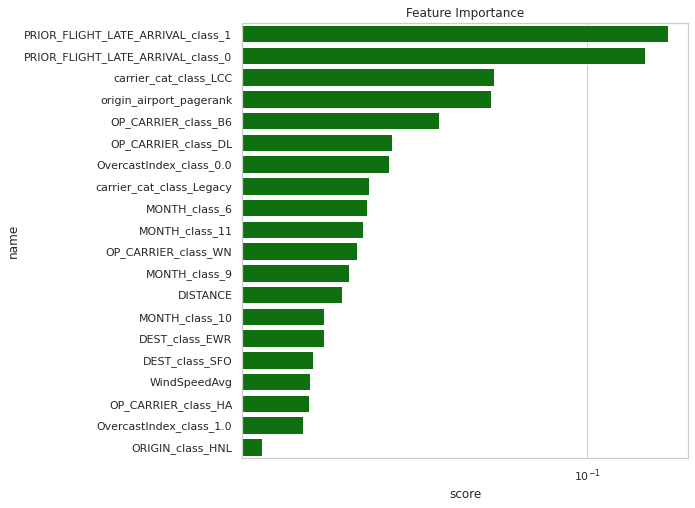

RandomForest train done

In [0]:
paramGrid_rf = {'numTrees': [338],
                'maxDepth': [3]}
train(param_grid = paramGrid_rf, 
      pipeline_f = pipeline_function, 
      modelName = "RandomForest", 
      trainDF = train_downsample, 
      testDF = test)

0

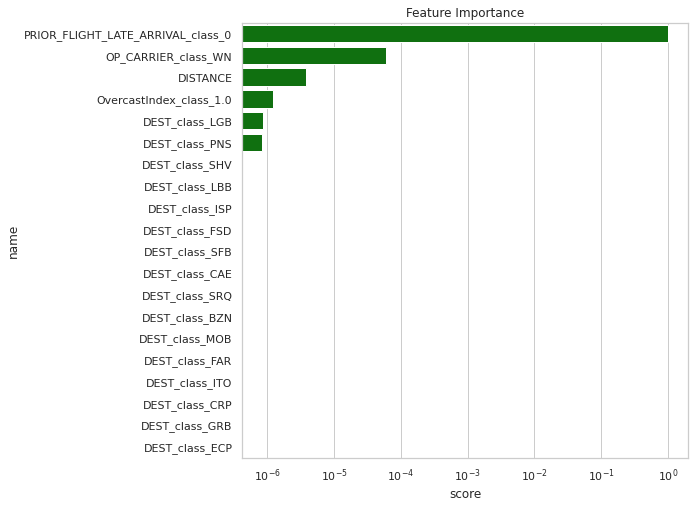

DecisionTree train done

In [0]:
paramGrid_dt = {'maxDepth': [5],
                'maxBins': [32]}
train(param_grid = paramGrid_dt, 
      pipeline_f = pipeline_function, 
      modelName = "DecisionTree", 
      trainDF = train_downsample, 
      testDF = test)

0

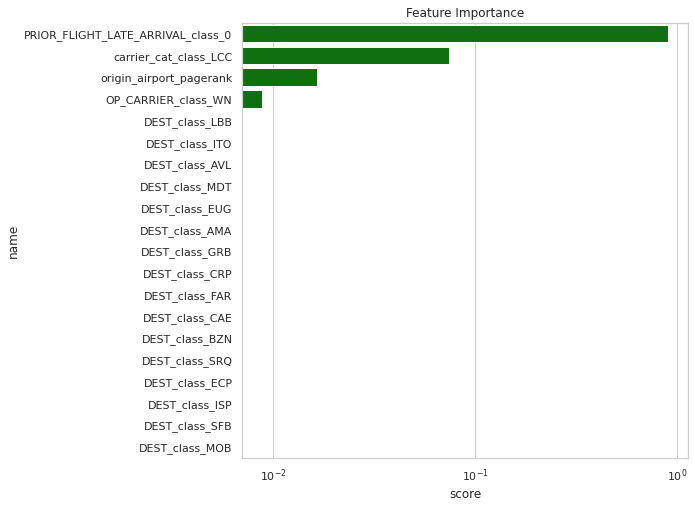

GBT train done

In [0]:
paramGrid_gbt = {"maxIter":[25], #Number of gradient boosting iterations 25, 75
                 "minInstancesPerNode":[1], #Minimum number of instances each leaf node must have 1,5
                 "maxDepth":[1], #Maximum depth of each tree 1,2,4
                 "maxBins":[128],
                 "stepSize":[0.1]}
train(param_grid = paramGrid_gbt, 
      pipeline_f = pipeline_function, 
      modelName = "GBT", 
      trainDF = train_downsample, 
      testDF = test)

In [0]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
import matplotlib.pyplot as plt
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
    
def evaluate_model(validation_prediction, classifier_name):
    """
    Input: predicted model for train and validation set, classifier name
    Output: PySpark DataFrame of evaluation metrics for class 0, 1 
    Confusion Matrix, PR-Curve
    """
    print('**********', classifier_name, '**********')
    rdd_valid_m = validation_prediction.select(['prediction', 'label']).rdd

    metrics_m_valid = MulticlassMetrics(rdd_valid_m)
    
    fig, axes = plt.subplots(figsize=(5,5))

    # Plot confusion matrix
    cm = metrics_m_valid.confusionMatrix().toArray()
    confusion_matrix = pd.DataFrame(cm)
    sns.heatmap(confusion_matrix,annot=True,cmap='rocket_r',fmt=',',ax=axes)
    axes.set_title('Confusion Matrix')
    axes.set_ylabel('Actual Values')
    axes.set_xlabel('Predicted Values')
    plt.show() 
    
def create_roc_curve(predictions):   
    # Returns as a list (false positive rate, true positive rate)
    preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    points = CurveMetrics(preds).get_curve('roc')

    plt.figure()
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(x_val, y_val)
    


## Ensemble

In [0]:
display(dbutils.fs.ls(f"{blob_url}/final_test/"))

path,name,size,modificationTime
wasbs://261finalproject@ssburgan.blob.core.windows.net/final_test/pred_DecisionTree/,pred_DecisionTree/,0,1659329881000
wasbs://261finalproject@ssburgan.blob.core.windows.net/final_test/pred_GBT/,pred_GBT/,0,1659285358000
wasbs://261finalproject@ssburgan.blob.core.windows.net/final_test/pred_LogisticRegression/,pred_LogisticRegression/,0,1659281459000
wasbs://261finalproject@ssburgan.blob.core.windows.net/final_test/pred_RandomForest/,pred_RandomForest/,0,1659283123000


In [0]:
#spark.sql.execution.arrow.enabled=False
predictions = dict()
confusion_matrices = dict()

# Logistic Regression
df_pred_lr = spark.read.parquet(f"{blob_url}/final_test/pred_LogisticRegression")
df_pred_lr = df_pred_lr.withColumn("pred_lr", df_pred_lr["prediction"])
df_pred_lr = df_pred_lr.withColumn("index", F.row_number().over(Window.orderBy(F.monotonically_increasing_id()))-1)
predictions["LogisticRegression"] = df_pred_lr

df_lr = df_pred_lr.groupBy("label").pivot("pred_lr").count()
df_pd_lr = df_lr.toPandas()
confusion_matrices["LogisticRegression"] = df_pd_lr

# Random Forest
df_pred_rf = spark.read.parquet(f"{blob_url}/final_test/pred_RandomForest")
df_pred_rf = df_pred_rf.withColumn("pred_rf", df_pred_rf["prediction"])
df_pred_rf = df_pred_rf.withColumn("index", F.row_number().over(Window.orderBy(F.monotonically_increasing_id()))-1)
predictions["RandomForest"] = df_pred_rf

df_rf = df_pred_rf.groupBy("label").pivot("pred_rf").count()
df_pd_rf = df_rf.toPandas()
confusion_matrices["RandomForest"] = df_pd_rf

# GBT
"""
df_pred_gbt = spark.read.parquet(f"{blob_url}/final_test/pred_GBT")
df_pred_gbt = df_pred_gbt.withColumn("pred_GBT", df_pred_gbt["prediction"])
df_pred_gbt = df_pred_gbt.withColumn("index", F.row_number().over(Window.orderBy(F.monotonically_increasing_id()))-1)
predictions["GBT"] = df_pred_gbt

df_GBT = df_pred_gbt.groupBy("label").pivot("pred_GBT").count()
df_pd_GBT = df_GBT.toPandas()
confusion_matrices["GBT"] = df_pd_GBT
"""

# Decision Tree
df_pred_dt = spark.read.parquet(f"{blob_url}/final_test/pred_DecisionTree")
df_pred_dt = df_pred_dt.withColumn("pred_dt", df_pred_dt["prediction"])
df_pred_dt = df_pred_dt.withColumn("index", F.row_number().over(Window.orderBy(F.monotonically_increasing_id()))-1)
predictions["DecisionTree"] = df_pred_dt

df_dt = df_pred_dt.groupBy("label").pivot("pred_dt").count()
df_pd_dt = df_dt.toPandas()
confusion_matrices["DecisionTree"] = df_pd_dt

In [0]:
lr_pred = predictions["LogisticRegression"]
rf_pred = predictions["RandomForest"]
#gbt_pred = predictions["GBT"]
dt_pred = predictions["DecisionTree"]
ensemble_pred = lr_pred.join(rf_pred[["index", "pred_rf"]], on=["index"], how="inner")
#ensemble_pred = ensemble_pred.join(gbt_pred[["index", "pred_GBT"]], on=["index"], how="inner")
ensemble_pred = ensemble_pred.join(dt_pred[["index", "pred_dt"]], on=["index"], how="inner")

In [0]:
ensemble_pred = ensemble_pred.withColumn("pred_sum", ensemble_pred["pred_lr"] + ensemble_pred["pred_rf"] + ensemble_pred["pred_dt"])
ensemble_pred = ensemble_pred.withColumn("final_pred", when(ensemble_pred["pred_sum"] > 2, 1.0).otherwise(0.0))

ensemble_pred_pivot = ensemble_pred.groupBy("label").pivot("final_pred").count().sort(col("label"))
ensemble_pred_pivot_pd = ensemble_pred_pivot.toPandas()

In [0]:
predictions["ensemble"] = ensemble_pred
confusion_matrices["ensemble"] = ensemble_pred_pivot_pd.rename(columns={"final_pred": "label"})

In [0]:
pd.options.display.float_format = '{:,.2f}'.format
def final_table(confusion_matrices):
    """Compute the final table of results from all models."""
    tbl = pd.DataFrame(columns="model TP TN FP FN".split())
    for model_name, conf_mat in confusion_matrices.items():
        tbl_row = {"model": model_name}
        cm = conf_mat.set_index("label")
#        tbl_row["TP"] = cm.loc[1.0, "0.0"]
#        tbl_row["TN"] = cm.loc[0.0, "1.0"]
#        tbl_row["FP"] = cm.loc[0.0, "1.0"]
#        tbl_row["FN"] = cm.loc[1.0, "0.0"]
        tbl_row["TN"] = cm.loc[1.0, "1.0"]
        tbl_row["TP"] = cm.loc[0.0, "0.0"]
        tbl_row["FP"] = cm.loc[1.0, "0.0"]
        tbl_row["FN"] = cm.loc[0.0, "1.0"]
        tbl = tbl.append(tbl_row, ignore_index=True)
    
    tbl['TP']=tbl['TP'].astype(float)
    tbl['TN']=tbl['TN'].astype(float)
    tbl['FP']=tbl['FP'].astype(float)
    tbl['FN']=tbl['FN'].astype(float)
    
    # Calculate evaluation metrics:
    TP, FP, TN, FN = tbl["TP"], tbl["FP"], tbl["TN"], tbl["FN"]
    tbl["precision"] = tbl["TP"] / (tbl["TP"] + tbl["FP"])
    tbl["recall"] = tbl["TP"] / (tbl["TP"] + tbl["FN"])
    tbl["specificity"] = tbl["TN"] / (tbl["TN"] + tbl["FP"])
    
    tbl["F2"] = 5 * ((tbl["precision"] * tbl["recall"]) / ((4 * tbl["precision"] + tbl["recall"])))
    tbl["MCC"] = (tbl["TP"] * tbl["TN"] - tbl["FP"] * tbl["FN"]) / np.sqrt((tbl["TP"] + tbl["FP"]) * (tbl["TP"] + tbl["FN"]) * (tbl["TN"] + tbl["FP"]) * (tbl["TN"] + tbl["FN"]))
    tbl["Balanced_Accuracy"] = (tbl["recall"] + tbl["specificity"])/2

    return tbl

In [0]:
tbl = final_table(confusion_matrices)
display(tbl)

model,TP,TN,FP,FN,precision,recall,specificity,F2,MCC,Balanced_Accuracy
LogisticRegression,554569.0,4914771.0,55981.0,470076.0,0.9083105396773401,0.5412303773502042,0.988737921344698,0.5888232008884868,0.6596299263939798,0.7649841493474511
RandomForest,554625.0,4914511.0,56241.0,470020.0,0.9079323452279223,0.5412850304251716,0.9886856153757017,0.5888431463063808,0.6594815626896813,0.7649853229004366
DecisionTree,554363.0,4914777.0,55975.0,470282.0,0.9082885220975918,0.5410293321101455,0.9887391284055209,0.5886309763729163,0.659482721858588,0.7648842302578331
ensemble,644906.0,3963682.0,1007070.0,379739.0,0.3903846060717589,0.6293945708025707,0.797400876165216,0.5607336055852686,0.3595834609232999,0.7133977234838933


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

def confusion_matrix(ax, modelName, TP, TN, FP, FN):
    arr = [[TN, FP], [FN, TP]]
    sns.heatmap(arr, annot=True, cmap= 'rocket_r', fmt=',', ax=ax)
    ax.set_title(f'{modelName}')
    ax.set_ylabel('Actual Values')
    ax.set_xlabel('Predicted Values')

In [0]:
lr, rf, dt, ensemble = list(tbl.iloc[0, :5]), list(tbl.iloc[1, :5]), list(tbl.iloc[2, :5]), list(tbl.iloc[3, :5])
dat = []
dat.append(lr)
dat.append(rf)
dat.append(dt)
dat.append(ensemble)

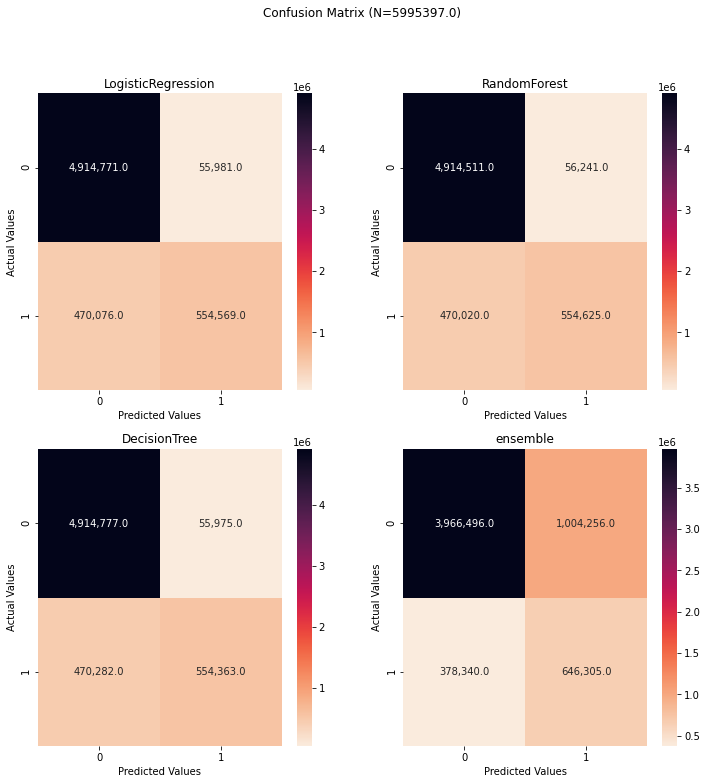

In [0]:
fig, axes = plt.subplots(2,2, figsize=(12, 12))
fig.suptitle(f"Confusion Matrix (N={sum(lr[1:])})")
for ax, values in zip(axes.flatten(), dat):
    confusion_matrix(ax, *values)

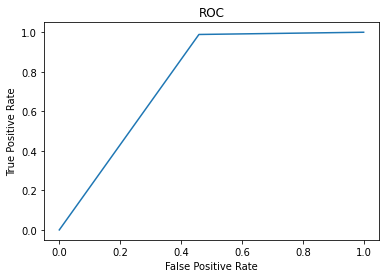

In [0]:
create_roc_curve(df_pred_lr)

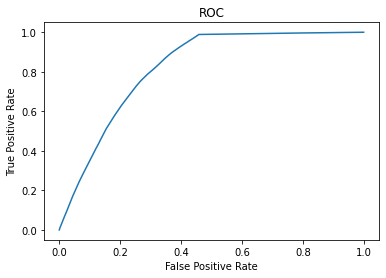

In [0]:
create_roc_curve(df_pred_rf)

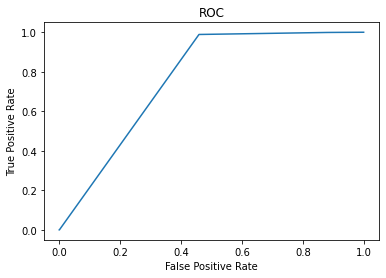

In [0]:
create_roc_curve(df_pred_dt)